# DDPM v3
In DDPM v3, we are going to further improve our DDPM model by exploring areas like changing default parameters of betamin/betamax, image pixel values range etc.

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [2]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

if fc.defaults.cpus>8: fc.defaults.cpus=8


The first change that we are making is scaling the images to have a pixel value of between -0.5 to 0.5, so that the overall range is 1. Contrast this with the standard approach of having pixel values between -1 and 1.

In [3]:
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))-0.5 for o in b[xl]]

bs = 256
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

Next, we want to try various scheduler parameters. We can use `SimpleNamespace` (which is like C's `struct`).

In [4]:
from types import SimpleNamespace

In [5]:
def linear_sched(betamin=0.0001, betamax=0.02, n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(0), sig=beta.sqrt())

Instead of using a linear scheduler, we can try using a cosine schedule instead.

In [6]:
def abar(t, T): return (t/T*math.pi/2).cos()**2

In [7]:
def cos_sched(n_steps=1000):
    ts = torch.linspace(0, n_steps-1, n_steps)
    ab = abar(ts, n_steps)
    alp = ab/abar(ts-1, n_steps)
    return SimpleNamespace(a=alp, abar=ab, sig=(1- alp).sqrt())

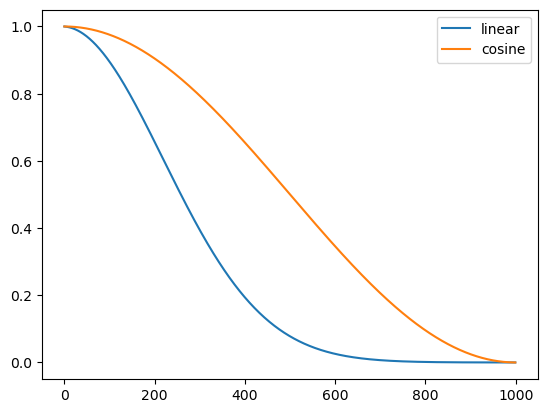

In [8]:
lin_abar = linear_sched().abar
cos_abar = cos_sched().abar
plt.plot(lin_abar, label='linear')
plt.plot(cos_abar, label='cosine')
plt.legend()

In [9]:
lin_abar.shape

torch.Size([1000])

Next, we want to calculate the gradients of `lin_abar` and `cos_abar` as they represent the learning rate of the model for denoising the image.

We approximate the gradients using numerical approximation. More specifically, $Δf(t)=f(t)−f(t−1)$ and $\lim_{Δt→0}​Δf(t)=\frac{df(t)}{dt}$.

Thus, the derivative is simply the difference between the n+1 and n element in the corresponding list.

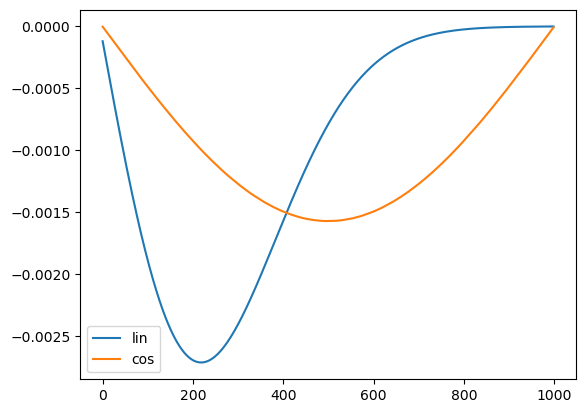

In [10]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

We see that the cosine abar has a much smoother curve as compared to the linear abar. Can we change linear abar to be more similar to cosine abar though?

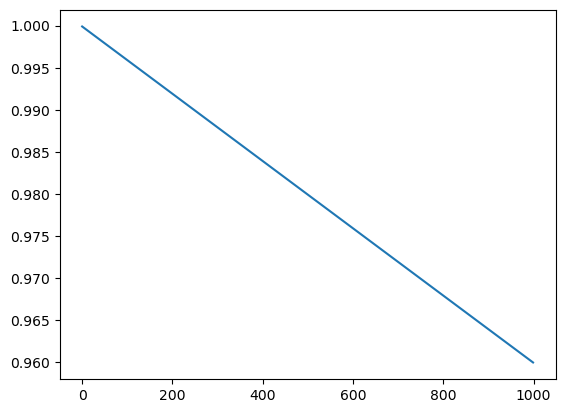

In [11]:
beta = torch.linspace(0.0001, 0.04, 1000)
alpha = (1.-beta)
plt.plot(alpha)

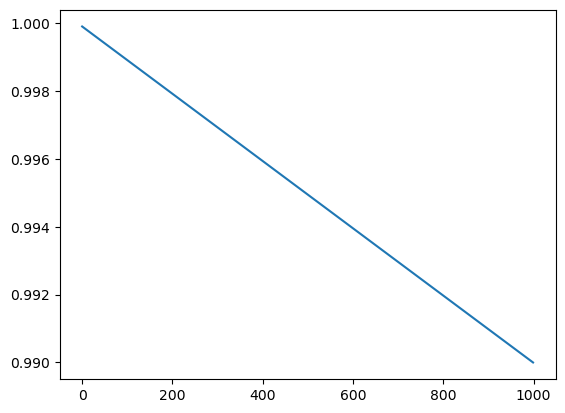

In [12]:
beta = torch.linspace(0.0001, 0.01, 1000)
alpha = (1.-beta)
plt.plot(alpha)

Smaller `betamax` values give us a 'higher ceiling', i.e. the value at time step 1000 is larger. Since `alphabar` is the cumulative product of `beta`, setting a smaller `betamax` value should give us a linear `alphabar` that is more similar in shape to the cosine `alphabar`.

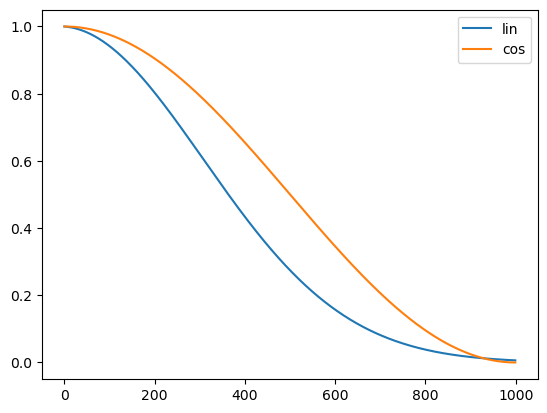

In [13]:
lin_abar = linear_sched(betamax=0.01).abar
plt.plot(lin_abar, label='lin')
plt.plot(cos_abar, label='cos')
plt.legend();

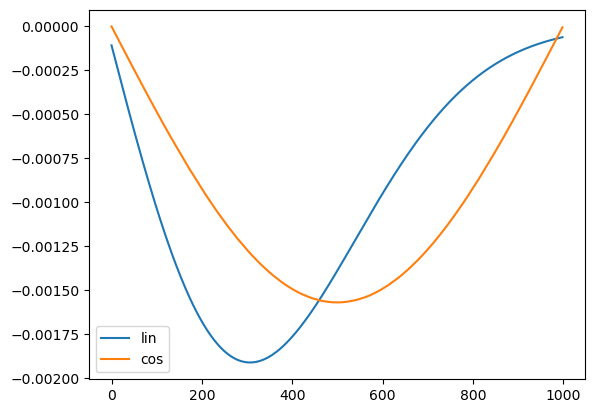

In [14]:
plt.plot(lin_abar[1:]-lin_abar[:-1], label='lin')
plt.plot(cos_abar[1:]-cos_abar[:-1], label='cos')
plt.legend();

While not perfect, the gradients of linear `abar` is closer to cosine `abar` with a smaller `betamax`.

Let's try training the model with these parameters to see if we can get lower FID scores.

In [15]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [16]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [17]:
dt = dls.train
xb, yb = next(iter(dt))

In [18]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([604, 665, 854, 684, 793, 246, 565, 911, 585, 311, 497, 104,  51, 260,
        516, 529, 861, 417, 468, 231, 469, 587, 246, 493, 157])

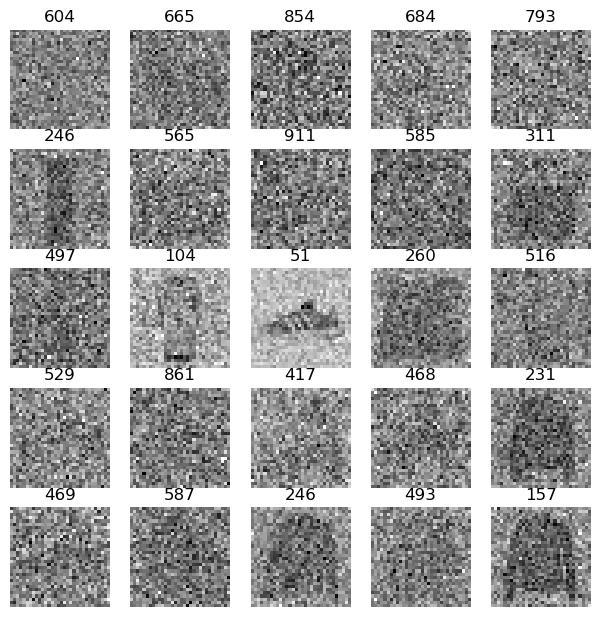

In [19]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25], imsize=1.5, titles=titles)

We see that our images make more sense even with noise added, as compared to previously when there was just too much noise.

## Training

In [20]:
from diffusers import UNet2DModel

In [21]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [22]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [23]:
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm)

In [24]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [25]:
lr = 1e-2
epochs = 5
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
init_ddpm(model)
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.116,0,train
0.033,0,eval
0.032,1,train
0.030,1,eval
0.027,2,train
0.026,2,eval
0.025,3,train
0.024,3,eval
0.023,4,train
0.024,4,eval


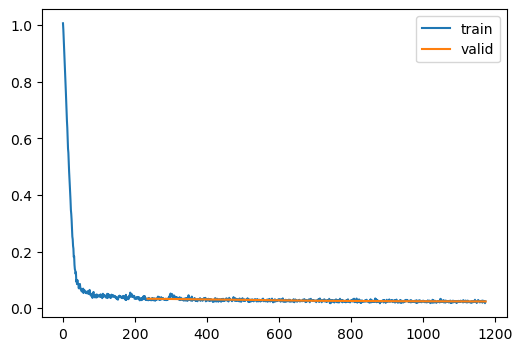

In [26]:
learn.fit(epochs)

In [27]:
mdl_path = Path('models')

In [28]:
torch.save(learn.model, mdl_path/'fashion_ddpm3_10.pkl')

## Skip sampling
Next, we will do skip sampling so that we do not pass our noisy image through the U Net for all 1000 itme steps. Instead, we will do so every 3rd step.

In [29]:
@torch.no_grad()
def sample_skip(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        if t%3==0 or t<50: noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().float())
    return preds

In [30]:
n_samples = 256

In [31]:
%%time
samples = sample_skip(model, (n_samples, 1, 32, 32))

CPU times: user 2min 14s, sys: 38.1 s, total: 2min 52s
Wall time: 8min 47s


In [32]:
s = (samples[-1]*2)

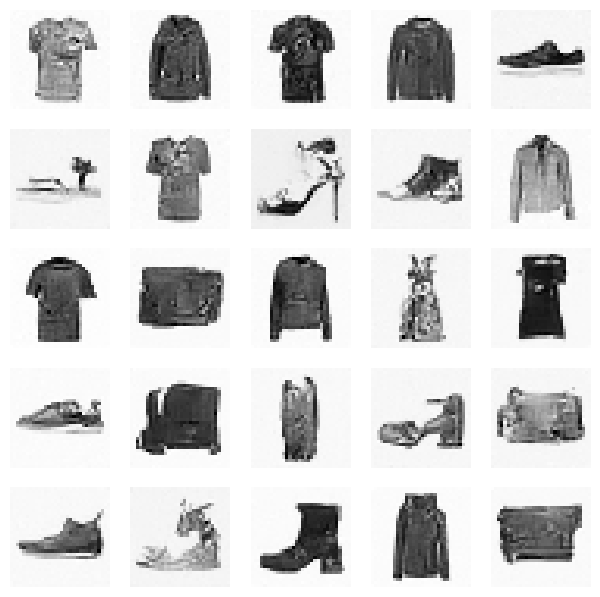

In [33]:
show_images(s[:25], imsize=1.5)

In [34]:
@inplace
def transformi2(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

tds2 = dsd.with_transform(transformi2)
dls2 = DataLoaders.from_dd(tds2, bs)

cmodel = torch.load('models/data_aug2.pkl')
del(cmodel[8])
del(cmodel[7])

In [35]:
from miniai.fid import ImageEval

In [36]:
ie = ImageEval(cmodel, dls2, cbs=[DeviceCB()])

In [37]:
ie.fid(s)

43.884033203125

We see a slight improvement over our previous model in `18_fid.ipynb`.